In [1]:
import os
import json
import numpy as np
from skimage.draw import disk
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize

def create_mask_from_json(json_data, shape):
    mask = np.zeros(shape, dtype=np.float32)
    for item in json_data:
        rr, cc = disk((item['y'], item['x']), item['radius'], shape=shape)
        mask[rr, cc] = 1.0
    return mask

def resize_labels(labels, original_size, new_size):
    scale_x = new_size[1] / original_size[1]
    scale_y = new_size[0] / original_size[0]
    resized_labels = []
    for label in labels:
        resized_label = {
            'x': label['x'] * scale_x,
            'y': label['y'] * scale_y,
            'radius': label['radius'] * scale_x  # Assuming uniform scaling in x and y
        }
        resized_labels.append(resized_label)
    return resized_labels

def load_images_and_labels(image_dir, label_dir, new_size):
    original_size = (1024, 1024)  # Original size of the images and labels
    image_files = [os.path.join(image_dir, file) for file in sorted(os.listdir(image_dir)) if file.endswith('.png')]
    label_files = [os.path.join(label_dir, file) for file in sorted(os.listdir(label_dir)) if file.endswith('.json')]

    images = []
    masks = []

    for image_file, label_file in zip(image_files, label_files):
        # Load and resize image
        image = img_to_array(load_img(image_file, color_mode='rgb', target_size=new_size))
        images.append(image / 255.0)  # Normalizing to [0, 1]

        # Load and resize corresponding label
        with open(label_file, 'r') as file:
            json_data = json.load(file)
        resized_json_data = resize_labels(json_data, original_size, new_size)
        mask = create_mask_from_json(resized_json_data, shape=new_size)
        masks.append(mask)

    return np.array(images), np.array(masks).reshape(-1, *new_size, 1)

# Usage
image_dir = './augmented_images'
label_dir = './augmented_labels'
new_size = (512, 512)  # Example new size
images, masks = load_images_and_labels(image_dir, label_dir, new_size)


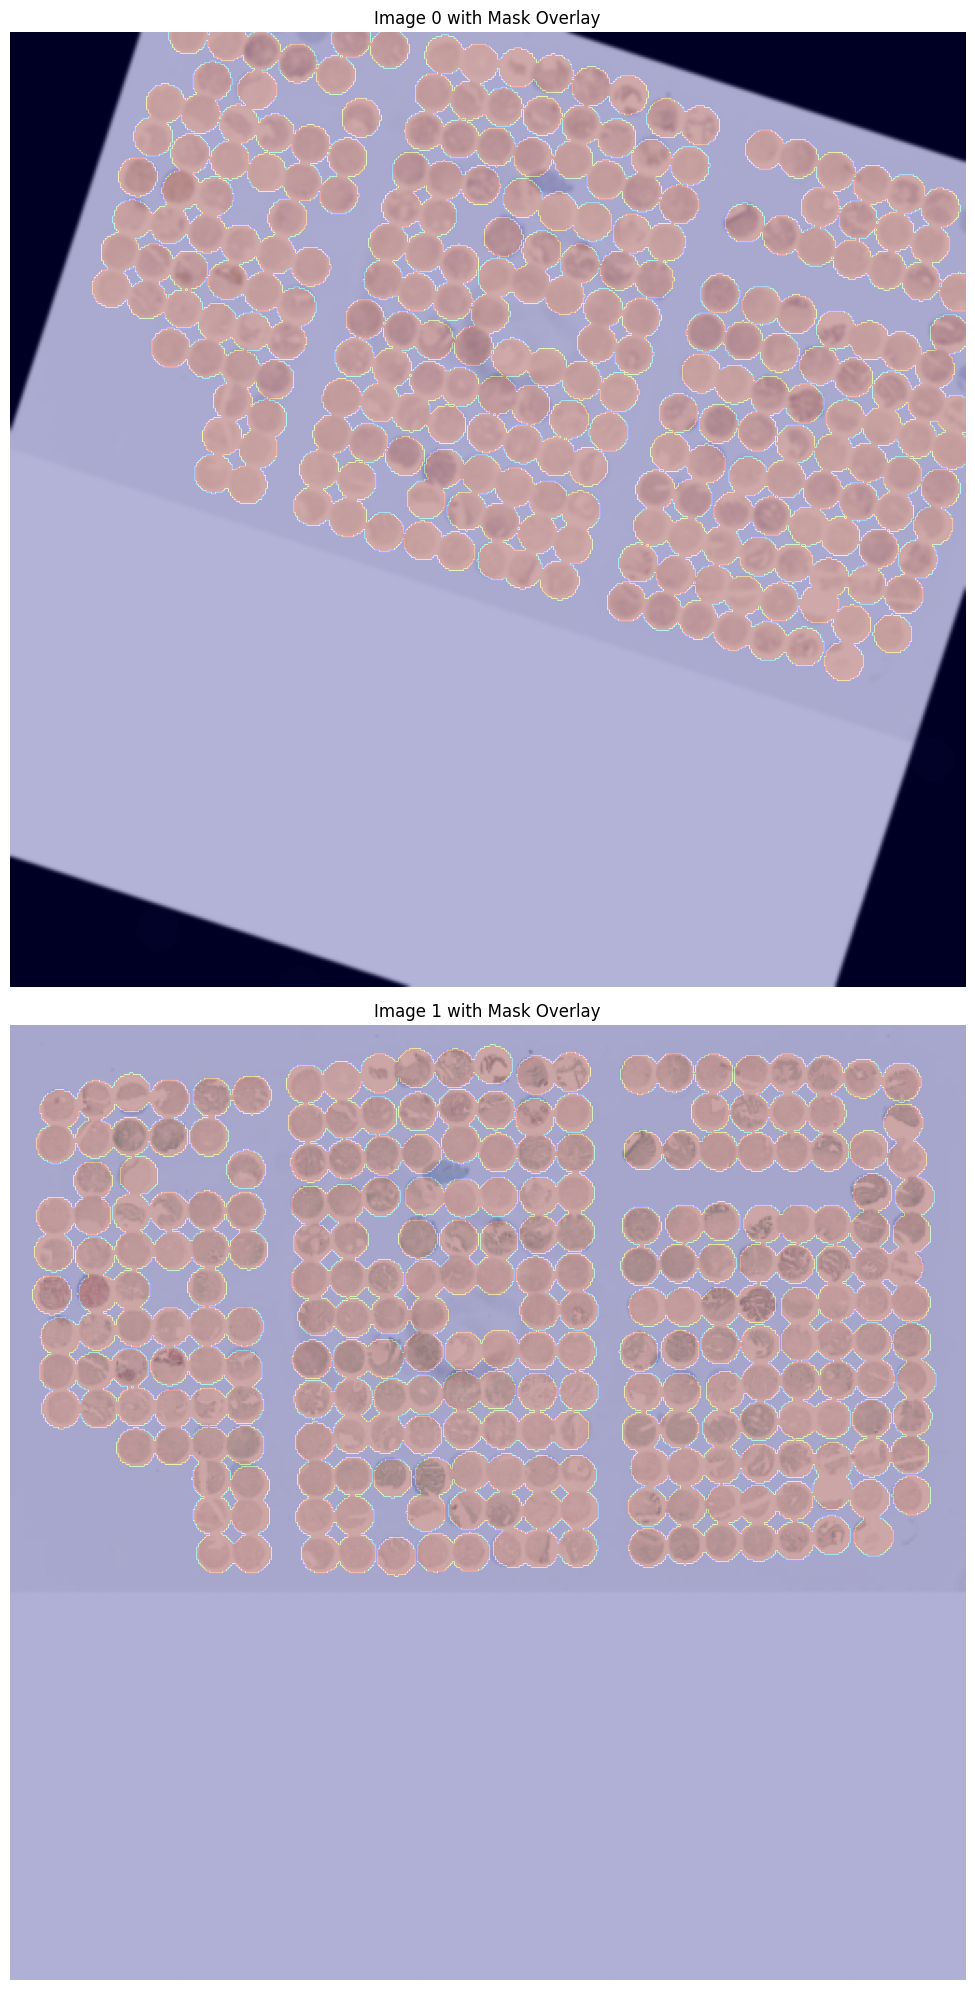

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
def verify_masks(images, masks, num_samples=3, mask_alpha=0.3):
    """
    This function overlays the mask onto the image to verify position and size.
    Parameters:
    - images: numpy array of images.
    - masks: numpy array of masks.
    - num_samples: number of samples to display for verification.
    - mask_alpha: transparency level of the mask overlay.
    """
    # Set the number of images to display
    num_samples = min(num_samples, len(images))

    # Create figure to display images and masks
    plt.figure(figsize=(20, num_samples * 10))

    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.imshow(masks[i].squeeze(), cmap='jet', alpha=mask_alpha)  # 'jet' colormap for the mask
        plt.title(f'Image {i} with Mask Overlay')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function after loading your images and masks
verify_masks(images, masks, num_samples=2, mask_alpha=0.3)




In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization, Activation

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def create_deeplabv3_plus_binary_model(input_shape=(512, 512, 3), l2_lambda=0.01, fine_tune_at=200):
    # Load MobileNetV2 pre-trained on ImageNet as the backbone
    backbone = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Unfreeze the top layers of the model for fine-tuning
    backbone.trainable = True
    for layer in backbone.layers[:fine_tune_at]:
        layer.trainable = False

    # Use features from the backbone network - feature extraction
    x = backbone.output

    # Apply atrous convolutions / spatial pyramid pooling
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.BatchNormalization()(x)

    # Atrous Spatial Pyramid Pooling (ASPP)
    b0 = layers.Conv2D(256, (1, 1), activation='relu', padding='same', dilation_rate=1, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=6, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    b2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=12, kernel_regularizer=regularizers.l2(l2_lambda))(x)
    b3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=18, kernel_regularizer=regularizers.l2(l2_lambda))(x)

    # Concatenate the atrous and image-level features
    x = layers.Concatenate()([b0, b1, b2, b3])

    # Add a convolutional layer on top of the concatenated features
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Decoder
    # Start with a simple 1x1 convolution
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(x)

    # Perform upsampling in steps to reach the output size of 512x512.
    # Each UpSampling2D layer doubles the size of the feature map
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 32x32
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 64x64
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 128x128
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 256x256
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # size becomes 512x512

    # Output layer for binary segmentation
    output = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs=backbone.input, outputs=output)

    return model

# Create the model
model = create_deeplabv3_plus_binary_model()

# Compile the model (if you're about to train it)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary to verify the architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 256, 256, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 256, 256, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 256, 256, 32)         0         ['bn_Conv1[0][0]']        

In [11]:
def conv_block(input_tensor, num_filters, kernel_size=3, do_batch_norm=True):
    # A conv block consists of two convolutions, each followed by a batch normalization and a relu activation.
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(input_tensor)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    if do_batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet(input_size=(512, 512, 3), num_filters=16, depth=2, dropout=0.5, batch_norm=True):
    # INPUT LAYER
    inputs = Input(input_size)
    # CONTRACTING PATH
    conv_blocks = []
    x = inputs
    for i in range(depth):
        x = conv_block(x, num_filters * (2**i), do_batch_norm=batch_norm)
        conv_blocks.append(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        if dropout:
            x = Dropout(dropout)(x)

    # BOTTLENECK
    x = conv_block(x, num_filters * (2**(depth)), do_batch_norm=batch_norm)
    
    # EXPANSIVE PATH
    for i in reversed(range(depth)):
        num_filters_exp = num_filters * (2**i)
        x = UpSampling2D(size=(2, 2))(x)
        x = concatenate([x, conv_blocks[i]], axis=3)
        x = conv_block(x, num_filters_exp, do_batch_norm=batch_norm)

    # FINAL CONVOLUTION
    output = Conv2D(1, 1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=output)

    return model

In [6]:
# Create the model
model = unet()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 512, 512, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 512, 512, 16)         64        ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 512, 512, 16)         0         ['batch_normalization_2[

In [16]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import os

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

# Define a Learning Rate Schedule
def scheduler(epoch, lr):
    if epoch < 50:
        return lr
    elif epoch%10 == 0:
        return lr * tf.math.exp(-0.1)
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

log_dir = "./tensorboard_logs"

def weighted_binary_crossentropy(zero_weight, one_weight):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_bce = weight_vector * bce

        return K.mean(weighted_bce)
    return loss

def train_unet(model, images, masks, epochs=200, batch_size=32, checkpoint_path='pixel_cores.hdf5'):
    # Define the custom loss function
    custom_loss = weighted_binary_crossentropy(zero_weight=1, one_weight=1)

    # Check if a previous checkpoint exists
    if os.path.exists(checkpoint_path):
        print(f"Loading weights from checkpoint: {checkpoint_path}")
        # Load the model with the custom loss function
        model = load_model(checkpoint_path, custom_objects={'loss': custom_loss})
    else:
        print("No checkpoint found. Starting training from scratch.")

    # Compile the model with the custom loss function
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=custom_loss, metrics=['AUC', 'accuracy', 'Precision', 'Recall'])
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True)
    
    # Define the TensorBoard callback
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_auc', patience=10, verbose=1, restore_best_weights=True)

    # Fit the model
    history = model.fit(images, masks, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1, 
                        callbacks=[model_checkpoint, tensorboard_callback, lr_scheduler, early_stopping])
    
    return history



In [17]:
from sklearn.model_selection import KFold

# Define the number of folds
num_folds = 10

# Initialize lists to store evaluation metrics for each fold
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

# Create an instance of KFold with the desired number of folds
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1234)

# Iterate over each fold
for train_index, val_index in kf.split(images):
    # Split the data into training and validation sets for the current fold
    train_images, val_images = images[train_index], images[val_index]
    train_masks, val_masks = masks[train_index], masks[val_index]

    # Create a new instance of your model
    model = unet()

    # Train the model on the training data for the current fold
    history = train_unet(model, train_images, train_masks)

    # Evaluate the model on the validation data for the current fold
    _, auc, accuracy, precision, recall = model.evaluate(val_images, val_masks)

    # Store the evaluation metrics for the current fold
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Calculate the average and standard deviation of the evaluation metrics across all folds
avg_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
avg_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
avg_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
avg_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

# Print the average and standard deviation of the evaluation metrics
print(f"Average AUC: {avg_auc:.4f} +/- {std_auc:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f} +/- {std_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f} +/- {std_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f} +/- {std_recall:.4f}")


Loading weights from checkpoint: pixel_cores.hdf5
Epoch 1/200
10/10 [==============================] - ETA: 0s - loss: 0.6746 - auc: 0.8712 - accuracy: 0.7266 - precision: 0.4261 - recall: 0.8562 
Epoch 1: val_loss improved from inf to 0.77762, saving model to pixel_cores.hdf5
10/10 [==============================] - 135s 13s/step - loss: 0.6746 - auc: 0.8712 - accuracy: 0.7266 - precision: 0.4261 - recall: 0.8562 - val_loss: 0.7776 - val_auc: 0.2278 - val_accuracy: 0.1290 - val_precision: 0.1030 - val_recall: 0.8971 - lr: 1.0000e-04
Epoch 2/200
10/10 [==============================] - ETA: 0s - loss: 0.6270 - auc: 0.8892 - accuracy: 0.7842 - precision: 0.4931 - recall: 0.8457 
Epoch 2: val_loss did not improve from 0.77762
10/10 [==============================] - 130s 13s/step - loss: 0.6270 - auc: 0.8892 - accuracy: 0.7842 - precision: 0.4931 - recall: 0.8457 - val_loss: 0.7782 - val_auc: 0.2265 - val_accuracy: 0.1235 - val_precision: 0.0988 - val_recall: 0.8575 - lr: 1.0000e-04
Epoc

In [4]:
def plot_training_predictions(model, training_images, training_masks, num_samples=3):
    # Make sure there is enough data for the number of samples requested
    if num_samples > len(training_images):
        num_samples = len(training_images)
        print(f"Number of available samples is less than requested. Setting num_samples to {num_samples}.")

    # Randomly select some samples from the training images and masks
    indices = np.random.choice(len(training_images), num_samples, replace=False)
    sample_images = np.array([training_images[i] for i in indices])
    sample_masks = np.array([training_masks[i] for i in indices])

    # Generate predictions for the sample_images
    predicted_masks = model.predict(sample_images)

    # Convert predicted masks to binary
    binary_predicted_masks = (predicted_masks > 0.114).astype(np.uint8)

    # Set up the matplotlib figure and axes, based on the number of samples
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    if num_samples == 1:
        axes = np.expand_dims(axes, 0)  # If only one sample, make sure axes are iterable

    for i in range(num_samples):
        # Display original image
        axes[i, 0].imshow(np.squeeze(sample_images[i]), cmap='gray')
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        # Display true mask for the image
        axes[i, 1].imshow(np.squeeze(sample_masks[i]), cmap='gray')
        axes[i, 1].set_title("True Mask")
        axes[i, 1].axis('off')

        # Display predicted mask for the image
        axes[i, 2].imshow(np.squeeze(binary_predicted_masks[i]), cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

plot_training_predictions(model, images, masks)


NameError: name 'model' is not defined